<div align=center>
		
<p></p>
<p></p>
<font size=5>
<font/>
<p></p>
 <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Department of Computer Engineering
</font>
<p></p>
<font color=blue>
Artificial Intelligence
</font>
<br/>
<br/>
Spring 2023

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 3 (Reinforcement Learning)
			</font>
    <br/>
                <br/>
    </div>

In this notebook you will use the [openai gym](https://www.gymlibrary.dev/) library to train agent in reinforcment learning environment. Our environment is a discrete-state env (and it is deterministic).
make sure to upload your model performance video alongside this notebook. We suggest running this notebook on google colab so that you wont face any package errors.

we will first install the necessary packages.

In [26]:
%pip install -q gym==0.26 imageio imageio_ffmpeg pygame pyglet==1.5.1 PyOpenGL xvfbwrapper pyvirtualdisplay swig

Note: you may need to restart the kernel to use updated packages.


the functions below will be used to make a video of the model performance. It will start the environment and choose the best action based on the given Qtable.

In [27]:
from IPython.display import HTML
from base64 import b64encode
import imageio
import random
import numpy as np

def record_video_taxi_env(env, Qtable, out_directory, fps=1, random_action=False):
    images = []
    done = False
    state, info = env.reset(seed=random.randint(0,500))
    img = env.render()
    images.append(img)
    while not done:
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.random.randint(6)  if random_action else np.argmax(Qtable[state][:])
        state, reward, done, truncated, info = env.step(action)
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def show_video(video_path, video_width = 500):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

## Part I: Taxi Environment (35 + 10 Points)

In [28]:
import numpy as np
import gym
import random
from tqdm import tqdm

In this exercise, we want to solve the Taxi-v3 environment. It is an environment, where we have a taxi, a passenger and a destination. taxi should go to the passenger's location, pick it up and then reach to destination and drop the passenger.
Please read more about this environment [here](https://www.gymlibrary.dev/environments/toy_text/taxi/)

**Question**  
Create an environment with the name `env` and print the number of states and actions.

In [29]:
env = gym.make('Taxi-v3')
print(f"total number of states: {env.observation_space.n}")
print(f"total number of actions: {env.action_space.n}")

total number of states: 500
total number of actions: 6


**Question**

Briefly describe the state space, action space, and reward function of this environment.

**Answer:**  
actions = ["UP", "Down", "Left", "Right", "Pick", "Drop"]
state space includes the possible positions of taxi which are [from (0, 0) to (4, 4)] and possible positions of passenger which are ["Green", "Yellow", "Blue", "Red", "In Taxi"] and possible destinations which are ["Green", "Yellow", "Blue", "Red"]

**Question**
 
Complete the code for `initialize_q_table` function. It should create a Q-table of size (state_space, action_space) and initializes it. You are free to use whichever initialization you want (a good starting point is to initialize it with all zeros)

In [30]:
def initialize_q_table(state_space, action_space):
    q_table = np.zeros((state_space, action_space))
    return q_table

In [31]:
Qtable = initialize_q_table(500, 6)

**Question**

Complete the code for `epsilon_greedy_policy` function. It should select the best action according to the current Q-function with probability $1-\varepsilon$ and select a random action with probability $\varepsilon$.

In [32]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    if random.uniform(0,1) > epsilon:
        return np.argmax(Qtable[state])
    return env.action_space.sample()

**Question**
You need to choose appropriate hyperparameters for the agent to learn.

In particular, you must find a suitable learning rate and exploration parameters. To facilitate exploration, a common practice is to start with a high exploration rate ($\varepsilon$) and gradually decrease it as the agent gets better. To implement this, you need to specify the starting exploration rate (`max_epsilon`), the final exploration rate (`min_epsilon`) and a decay rate which reduces the exploration rate after each update (see the `train` function below).

In [40]:
# Training parameters
n_training_episodes = 25000  # Total training episodes
n_eval_episodes = 200
learning_rate = 0.01        # Learning rate

# Environment parameters
max_steps = 200             # Max steps per episode
gamma = 0.99                # Discounting rate

# Exploration parameters
max_epsilon = 1.0           # Exploration probability at start
min_epsilon = 0.001         # Minimum exploration probability
decay_rate = 0.01           # Exponential decay rate for exploration prob

**Question**

Complete the `train` function which updates `Qtable` using the Q-learning update rule.

In [41]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for i in tqdm(range(n_training_episodes)):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*i)
        state, _ = env.reset()
        done = False
        
        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, done, _, _ = env.step(action)
            Qtable[state, action] += learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state, action]) 
            state = new_state
            
            if done:
                break

    return Qtable

We are now ready to train our agent.

In [42]:
Qtable_trained = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

100%|██████████| 25000/25000 [00:09<00:00, 2618.92it/s]


Now, we will evaluate our agent.

In [43]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q_table):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and return the mean reward and standard deviation of the rewards.
    
    :param env: The evaluation environment
    :param max_steps: Maximum number of steps per episode
    :param n_eval_episodes: Number of episodes to evaluate the agent
    :param Q_table: The Q-table
    """
    episode_rewards = []
    
    for episode in tqdm(range(n_eval_episodes)):
        state, _ = env.reset()
        total_rewards_ep = 0
        terminated = False
        
        for step in range(max_steps):
            action = np.argmax(Q_table[state, :])
            new_state, reward, terminated, _, _ = env.step(action)
            total_rewards_ep += reward
            state = new_state
            
            if terminated:
                break
            
        episode_rewards.append(total_rewards_ep)
    
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [49]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_trained)
print(f"Mean_reward = {mean_reward:.2f}")

100%|██████████| 200/200 [00:00<00:00, 4078.53it/s]

Mean_reward = 8.06


Next, we will take a look at the Q-function that was learned.

In [50]:
print(Qtable_trained)

[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.66470834 -2.93085073 -3.35598515 -2.67662407  9.6220697  -3.45079335]
 [-1.49822449 -1.62545981 -1.51255265 -1.48049996 14.11880599 -1.5768562 ]
 ...
 [-0.69681911 -0.61262771 -0.69758949 -0.706608   -0.79226615 -0.79245757]
 [-2.25863306 -2.27261719 -2.25364326 -1.63819683 -2.39193275 -2.48709385]
 [-0.02989801 -0.04820493 -0.02417187  1.87709419 -0.1        -0.1       ]]


**Question**

Assume that `Qtable_trained` is the correct Q-function for the final epsilon-greedy policy that was used in training. What is the value function that corresponds to this policy? Write down the relation between $V_\pi$ and $Q_\pi$ and use it to complete the following code block.

**Answer:**

$$
V_\pi(s) = \max_a Q_\pi(s, a)
$$

In [58]:
def compute_value_function(Qtable):
    Vtable = np.max(Qtable, axis=1)
    return Vtable

Vtable_trained = compute_value_function(Qtable_trained)

Take a look at the value function

In [59]:
print(Vtable_trained)

[ 0.          9.6220697  14.11880599 10.72936333 -5.43693112  0.
 -4.44655269 -2.86460004  3.80479634  0.88591475  0.         -0.44916
 -3.82628242 -1.3419434  -3.1860585   0.         20.         10.72936333
 15.2715212  11.84784175  0.          5.55655007  9.91655016  5.99202061
 -2.86210551  0.         -2.98296845 -0.31473943  3.29058207 -0.41461912
  0.         -0.48463837 -0.40604095  1.77800973 -1.02286742  0.
  2.09479554 -2.10790572 -0.40390778 -0.45293549  0.         -1.92605248
  1.46746719 -1.06870994  1.98319767  0.          2.82024939  5.59822849
  1.88650621 -2.65912381  0.         -1.51862023  0.10999637  1.6456692
 -0.74344316  0.         -1.47883576 -0.09570184 -0.85244595 -0.61091557
  0.         -2.44605667  0.59963765  0.70929058  7.75550891  0.
  7.80017419 11.25945508  3.91672145 -1.07811715  0.          0.63249018
  2.53374079  6.30691286  4.3272447   0.         11.84784175  1.70171347
 11.84784175  1.40658145  0.         -5.08930951 -1.97603725 -4.15283203
  9.62

**Question**  
Write a function to generate a visualization for the value function.

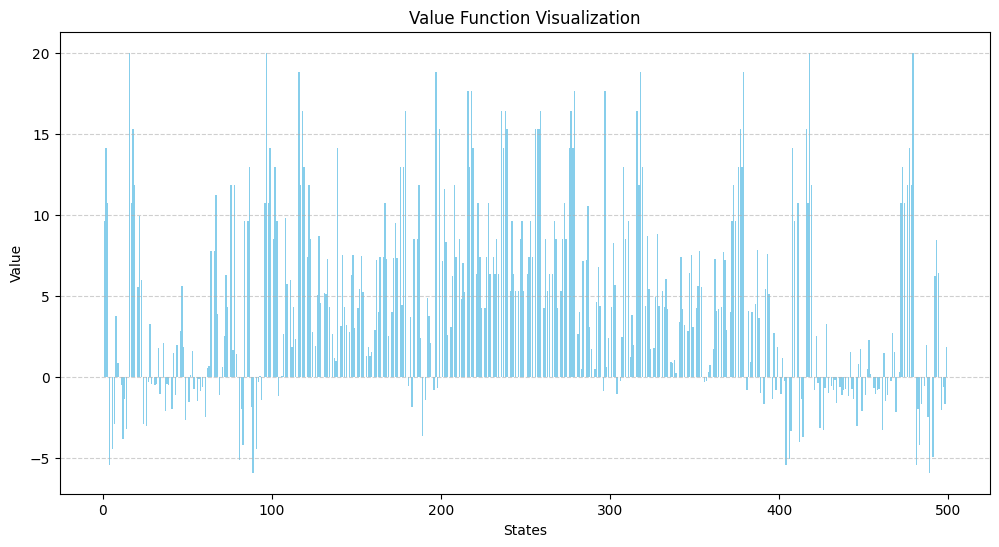

In [63]:
import matplotlib.pyplot as plt

def visualize(Vtable):
    """
    Visualize the value function
    :param Vtable: The value function
    """
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(Vtable)), Vtable, color='skyblue')
    
    plt.title('Value Function Visualization')
    plt.xlabel('States')
    plt.ylabel('Value')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.show()

visualize(Vtable_trained)